In [1]:
from PIL import Image
import os
import glob
from keras.preprocessing import image
import keras.preprocessing
import tensorflow as tf

In [18]:
train_gen = image.ImageDataGenerator(
    rescale = 1/255.0,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
)

test_gen = image.ImageDataGenerator(rescale=1/255.0)

In [19]:
train_generator = train_gen.flow_from_directory(
    r"D:\\Github\\Oral-cancer\\Phase 1\\Tongue\\Train\\",
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'binary')

Found 280 images belonging to 2 classes.


In [20]:
train_generator.class_indices

{'Cancer': 0, 'Non Cancer': 1}

In [21]:
val_generator = test_gen.flow_from_directory(
    r"D:\\Github\\Oral-cancer\\Phase 1\\Tongue\\Val\\",
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'binary')

Found 94 images belonging to 2 classes.


In [6]:
# Create the VGG16 models

from keras.applications.vgg16 import VGG16
import keras
from keras.layers import *
from keras.models import Model 
import matplotlib.pyplot as plt

In [22]:
model = VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))
for layer in model.layers:
    layer.trainable=False

In [23]:
av1 = Flatten()(model.output)
fc1 = Dense(64,activation='relu')(av1)
d1 = Dropout(0.6)(fc1)
fc2 = Dense(1,activation='softmax')(d1)
model_new = Model(model.input,fc2)
model_new.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [24]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model_new.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'])

In [25]:
hist = model_new.fit(
    train_generator,
    steps_per_epoch = 4,
    epochs = 10,
    batch_size=8,
    validation_data = val_generator,
)

Epoch 1/10
4/4 [==============================] - 39s 7s/step - loss: 1.8343 - accuracy: 0.6875 - val_loss: 0.5991 - val_accuracy: 0.6702
Epoch 2/10
4/4 [==============================] - 5s 2s/step - loss: 0.6498 - accuracy: 0.6094 - val_loss: 0.7976 - val_accuracy: 0.6702
Epoch 3/10
4/4 [==============================] - 6s 2s/step - loss: 0.7939 - accuracy: 0.6406 - val_loss: 0.3426 - val_accuracy: 0.6702
Epoch 4/10
4/4 [==============================] - 5s 2s/step - loss: 0.2695 - accuracy: 0.7188 - val_loss: 0.3769 - val_accuracy: 0.6702
Epoch 5/10
4/4 [==============================] - 15s 5s/step - loss: 0.4243 - accuracy: 0.6607 - val_loss: 0.2734 - val_accuracy: 0.6702
Epoch 6/10
4/4 [==============================] - 6s 2s/step - loss: 0.3145 - accuracy: 0.6406 - val_loss: 0.3833 - val_accuracy: 0.6702
Epoch 7/10
4/4 [==============================] - 6s 2s/step - loss: 0.3490 - accuracy: 0.6094 - val_loss: 0.3012 - val_accuracy: 0.6702
Epoch 8/10
4/4 [=======================

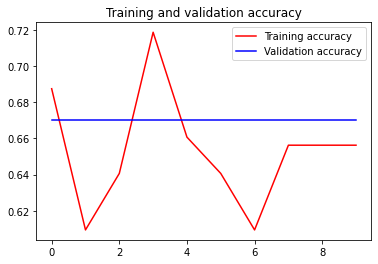

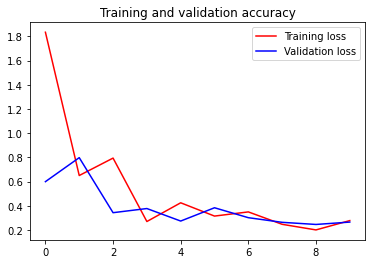

In [26]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.legend(loc=0)
plt.title('Training and validation accuracy')

plt.show()

In [8]:
from keras.applications.vgg19 import VGG19

In [12]:
model = VGG19(include_top=False, weights='imagenet', input_shape=(224,224,3))
for layer in model.layers:
    layer.trainable=False

NameError: name 'VGG19' is not defined

In [16]:
av1 = Flatten()(model.output)
fc1 = Dense(64,activation='relu')(av1)
d1 = Dropout(0.6)(fc1)
fc2 = Dense(1,activation='softmax')(d1)
model_new = Model(model.input,fc2)
model_new.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [17]:
adam = tf.keras.optimizers.Adam(learning_rate=0.003)
model_new.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'])

In [18]:
hist = model_new.fit(
    train_generator,
    steps_per_epoch = 4,
    epochs = 10,
    batch_size=16,
    validation_data = val_generator,
)

Epoch 1/10
4/4 [==============================] - 7s 1s/step - loss: 0.6829 - accuracy: 0.4206 - val_loss: 0.8423 - val_accuracy: 0.6250
Epoch 2/10
4/4 [==============================] - 3s 611ms/step - loss: 0.7548 - accuracy: 0.4393 - val_loss: 0.6884 - val_accuracy: 0.6250
Epoch 3/10
4/4 [==============================] - 3s 657ms/step - loss: 0.6258 - accuracy: 0.4299 - val_loss: 0.6157 - val_accuracy: 0.6250
Epoch 4/10
4/4 [==============================] - 3s 651ms/step - loss: 0.6283 - accuracy: 0.4579 - val_loss: 0.5686 - val_accuracy: 0.6250
Epoch 5/10
4/4 [==============================] - 4s 823ms/step - loss: 0.5737 - accuracy: 0.4299 - val_loss: 0.5660 - val_accuracy: 0.6250
Epoch 6/10
4/4 [==============================] - 3s 658ms/step - loss: 0.5839 - accuracy: 0.4766 - val_loss: 0.5060 - val_accuracy: 0.6250
Epoch 7/10
4/4 [==============================] - 3s 721ms/step - loss: 0.5393 - accuracy: 0.4609 - val_loss: 0.4742 - val_accuracy: 0.6250
Epoch 8/10
4/4 [=======